THINGS TO CHECK
- check rescale
- load on demand vs load on init

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [27]:
import os, sys
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

In [ ]:
! unzip /content/notebooks/dataset.zip -d /content/

In [2]:
import albumentations as A
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers.models.oneformer.image_processing_oneformer import load_metadata, prepare_metadata

True

In [ ]:
# config.py
import os

MAIN_PROJECT_DIR = "/content/drive/MyDrive/galaxy_segmentation/"
DATASET_DIR = "/content/dataset/"

CLASS_INFO_PATH = os.path.join(MAIN_PROJECT_DIR, 'class_info.json')

CLASS_MAPPING = {
    'Ei': 'elliptical', 'Er': 'elliptical', 'Ec': 'elliptical',
    'Sa': 'spiral', 'Sb': 'spiral', 'Sc': 'spiral', 'Sd': 'spiral',
    'SBa': 'spiral barred', 'SBb': 'spiral barred', 'SBc': 'spiral barred', 'SBd': 'spiral barred',
    'Sen': 'spiral edge-on', 'Ser': 'spiral edge-on', 'Seb': 'spiral edge-on',
    'A': 'artifact'
}

GALAXY_MEAN = [8.9483, 6.2549, 5.1239]
GALAXY_STD = [14.9211, 12.5903, 8.8366]

In [ ]:
# visual.py
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_distribution(distributions, labels):
    fig, axs = plt.subplots(1, len(distributions))
    fig.set_size_inches(15, 5)
    for distribution, label, axis in zip(distributions, labels, axs):
        key_labels = [el.split(" ")[-1] for el in distribution.keys()]
        axis.bar(key_labels, distribution.values())
        axis.set_title(label)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

def display_n_samples(dataset, n, from_dir=True):
    """
    Call display_top_masks over n images
    Args:
        dataset: 
            the dataset from which the image will be picked
        n (int): 
            how many samples to show
        from_dir (bool): 
            wether loading the image from the real directory or directly use the dataset output
    """
    if from_dir:
        images = np.random.choice(dataset.image_info, n)
        for image_obj in images:
            image = dataset.load_image(image_obj)
            mask = dataset.load_mask(image_obj)
            class_ids = np.array([int(x) for x in image_obj["class_ids"]])
            display_top_masks(image, mask, class_ids, dataset.class_names)
    else:
        idxs = np.random.choice(np.arange(len(dataset)), 3)
        for idx in idxs:
            el = dataset[idx]
            display_images([el["pixel_values"].permute((1,2,0)), el["mask_labels"][1]], None, 2)
        

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(6, 6 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        if isinstance(image, np.ndarray):
            image = image.astype(np.uint8)
        plt.imshow(image, cmap=cmap, norm=norm, interpolation=interpolation)
        i += 1
    plt.show()
    
def display_top_masks(image, mask, class_ids, class_names, limit=1):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))

    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]])
                 for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),
                                    key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")

In [ ]:
# dataset.py
import os
import torch
import json
import numpy as np
import skimage.color
import skimage.io
import skimage.transform
import multiprocessing as mp
import torch.nn.functional as F
from torch.utils.data import Dataset


class GalaxyDataset(Dataset):
    def __init__(self, dataset_dir, subset, processor, cls_mapping_path, transform, mean, std, load_on_demand=False, max_obj=2):
        self.image_info = []
        self.image_data = []
        self.mask_data = []
        self.dataset_classes = []

        self.dataset_dir = dataset_dir
        self.subset = subset
        self.processor = processor
        self.class_mapping = self.load_cls_mapping(cls_mapping_path)
        self.transform = transform
        self.mean = mean
        self.std = std
        self.load_on_demand = load_on_demand
        self.max_obj = max_obj      # maximum number of objects within a segmentation map
        self.load_galaxia(dataset_dir, subset)
    
    def __len__(self):
        return len(self.image_info)

    def __getitem__(self, idx):
        if self.load_on_demand:
            image_info = self.image_info[idx]
            image = skimage.io.imread(image_info['path'])
            mask = self.load_mask(image_info)

        else:
            image = self.image_data[idx]
            mask = self.mask_data[idx]
        
        # Prepare task inputs
        task_inputs = ["semantic"]
        
        # Apply transform augmentation
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            transformed_image = transformed['image']
            transformed_mask = transformed['mask']

        # Apply the processor to the image and masks
        encoded_inputs = self.processor(
            images=transformed_image,
            task_inputs=task_inputs,
            segmentation_maps=np.squeeze(transformed_mask),     # squeeze is necessary because the image processor expect ndims=2
            return_tensors="pt",
            image_mean=self.mean,
            image_std=self.std
        )
        
        # Extract the required outputs
        # binary_masks = encoded_inputs["pixel_values"]
        # labels = torch.tensor(class_ids, dtype=torch.int64)
        # text_inputs = encoded_inputs["text_inputs"]
        # task_inputs = encoded_inputs["task_inputs"]
        
        # return binary_masks, labels, text_inputs, task_inputs
        inputs = {k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in encoded_inputs.items()}
        # self.type_conversion(inputs)

        """
        It may happen that the rotation augmentation make some masks fall outside the input frame.
        When this happens the segmentation map is empty (all background).
        In this case we have to pad to the maximum number of elements that can be present within a single segmentation map.
        """
        dim = self.max_obj - inputs["mask_labels"].shape[0]
        inputs["mask_labels"] = F.pad(inputs["mask_labels"], (0, 0, 0, 0, dim, 0), "constant", 1)
        inputs["class_labels"] = F.pad(inputs["class_labels"], (0, dim), "constant", 0)
        
        return inputs

    def get_unorm_image(self, idx):
        image = self.__getitem__(idx)["pixel_values"]
        original_image = skimage.io.imread(self.image_info[idx]["path"])
        image_average = original_image.mean(axis=(0,1))
        image_std = original_image.std(axis=(0,1))
        unnormalized_image = (image.numpy() * np.array(image_std)[:, None, None]) + np.array(image_average)[:, None, None]
        return np.moveaxis(unnormalized_image, 0, -1).astype(np.uint8)

    @property
    def class_names(self):
        return list(self.class_mapping.values())

    @property
    def reverse_class_mapping(self):
        """From names to ids"""
        return {y: x for x, y in self.class_mapping.items()}

    def load_cls_mapping(self, cls_mapping_path):
        with open(cls_mapping_path) as fp:
            d = json.load(fp)

        class_mapping = {k:v["name"] for k,v in d.items()}
        assert class_mapping != {}
        return class_mapping

    def load_galaxia(self, dataset_dir, subset):
        """Load a subset of the galaxyzoo dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train, val or test
        """
        # Add classes
        for cls, id in self.class_mapping.items():
            self.add_class("galaxia", id, cls)

        assert subset in ["train", "val", "test"]

        dataset = json.load(open(os.path.join(dataset_dir, "galaxy_"+subset+".json")))
        dataset = list(dataset.values())

        # Skip unannotated images
        dataset = [a for a in dataset if a['regions']]

        # Add images
        for galxy_obj in dataset:
            
            # The dataset can have more than just one object per image
            if type(galxy_obj['regions']) is dict:
                polygons = [r['shape_attributes'] for r in galxy_obj['regions'].values()]
                objects = [s['region_attributes'] for s in galxy_obj['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in galxy_obj['regions']]
                objects = [s['region_attributes'] for s in galxy_obj['regions']]
                        
            class_ids = []
            
            # Add the ids according to the class_mapping
            for obj in objects:
                class_ids.append(self.reverse_class_mapping[obj["object_name"]])
            
            # load_mask() needs the image size to convert polygons to masks.
            image_path = os.path.join(dataset_dir, "original/zoo2Main", galxy_obj['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "galaxia",
                image_id=galxy_obj['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=class_ids)


    @staticmethod
    def type_conversion(encoded_inputs):
        """Convert statically the dtype of the encoded_inputs fields"""
        encoded_inputs["pixel_values"] = encoded_inputs["pixel_values"].to(torch.float16)
        encoded_inputs["pixel_mask"] = encoded_inputs["pixel_mask"].to(torch.int16)
        encoded_inputs["mask_labels"] = encoded_inputs["mask_labels"].to(torch.float16)
        encoded_inputs["class_labels"] = encoded_inputs["class_labels"].to(torch.int16)


    def load_image(self, image_obj):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(image_obj['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image

    def load_mask(self, image_info):
        """Generate instance masks for an image.
        Returns:
            masks: A bool array of shape [height, width, instance count] with one mask per instance.
        """        
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape [height, width, instance_count]
        mask = np.zeros([image_info["height"], image_info["width"], len(image_info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(image_info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to class_id
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = class_ids[i]
            
        return mask

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "galaxia":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def add_class(self, source, class_id, class_name):
        """Add a new class to the dataset."""
        self.dataset_classes.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })
    
    def add_image(self, source, image_id, path, **kwargs):
        """Add a new image to the dataset."""
        image_info = {
            "source": source,
            "id": image_id,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)
        if not self.load_on_demand:
            self.image_data.append(skimage.io.imread(image_info["path"]))
            self.mask_data.append(self.load_mask(image_info))



In [3]:
# model_card = "shi-labs/oneformer_coco_dinat_large"
model_card = "shi-labs/oneformer_ade20k_swin_tiny"
model = OneFormerForUniversalSegmentation.from_pretrained(model_card, is_training=True)
processor = OneFormerProcessor.from_pretrained(model_card)

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_coco_dinat_large and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

In [4]:
# Metadata must be set according to the dataset through the class_info.json file. Background class must be specified as well.
processor.image_processor.repo_path = MAIN_PROJECT_DIR
processor.image_processor.class_info_file = os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)
processor.image_processor.metadata = prepare_metadata(load_metadata(MAIN_PROJECT_DIR, os.path.join(MAIN_PROJECT_DIR, CLASS_INFO_PATH)))
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx
processor.image_processor.do_resize = False
processor.image_processor.do_rescale = False

In [5]:
# Augmentations
transform = A.Compose([
    A.OneOf([
        A.Compose([
            A.HorizontalFlip(p=1),
            A.VerticalFlip(p=1),
            A.OneOf([
                A.Rotate(limit=(90), p=1),
                A.Rotate(limit=(180), p=1),
                A.Rotate(limit=(270), p=1)
            ], p=1)
        ]),
        A.NoOp()
    ], p=1.0)
])

In [6]:
dataset_train = GalaxyDataset(DATASET_DIR, "train", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD)
dataset_val = GalaxyDataset(DATASET_DIR, "val", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD)
dataset_test = GalaxyDataset(DATASET_DIR, "test", processor, CLASS_INFO_PATH, transform, GALAXY_MEAN, GALAXY_STD)

In [ ]:
display_n_samples(dataset_test, 3)

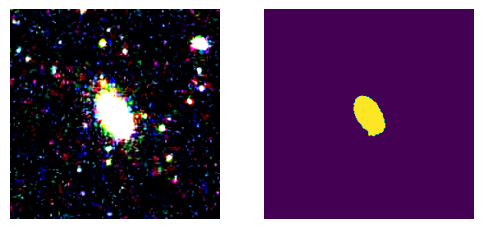

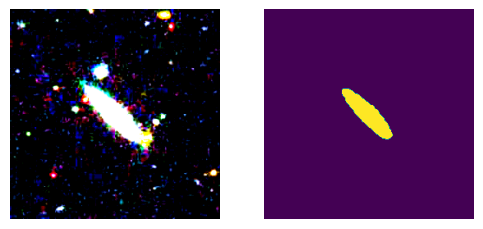

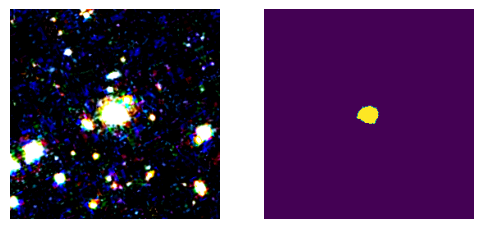

In [78]:
display_n_samples(dataset_train, 3, False)

In [10]:
batch_size = 4
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
n_epochs = 2
optimizer = AdamW(model.parameters(), lr=5e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"


model.train()
model.model.is_training = True
model.to(device)
for epoch in range(n_epochs):  # loop over the dataset multiple times
  print(f"Epoch {epoch+1}")
  running_loss = 0
  for batch_idx, batch in enumerate(train_dataloader):

      # zero the parameter gradients
      optimizer.zero_grad()

      batch = {k:v.to(device) for k,v in batch.items()}
      # forward pass
      outputs = model(**batch)

      running_loss += outputs.loss.item()
      if (batch_idx + 1) % (len(train_dataloader) // 20) == 0 or batch_idx < 50:
        avg_loss = running_loss / (batch_idx + 1)
        print(f"Avg loss at iteration n. {(batch_idx + 1)} / {len(train_dataloader)}: {avg_loss}")

      outputs.loss.backward()
      optimizer.step()

In [ ]:
model.eval()
model.model.is_training = False

image = Image.open(dataset_test.image_info[2]["path"])
inputs = processor(images=image, task_inputs=["instance"], return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

In [ ]:
semantic_segmentation = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]